# QSCOUT Optimizations with Qiskit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/qscout/qscout_qss.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/qscout/qscout_qss.ipynb)

Below is a brief tutorial on Superstaq optimizations for Quantum Scientific Computing Open User Testbed (QSCOUT), a trapped ion quantum computing testbed at Sandia National Laboratory. For more information on QSCOUT, visit their website [here](https://www.sandia.gov/quantum/quantum-information-sciences/projects/qscout/).

## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq[examples]`:

In [1]:
# Required imports
try:
    import qiskit
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit
    import qiskit_superstaq as qss

import numpy as np

# Optional imports
import os  # Used if setting a token as an environment variable

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [2]:
# Get the qiskit superstaq provider for Superstaq backend
provider = qss.SuperstaqProvider()

## Single Circuit Compilation

Let us start by creating an example qiskit circuit that we will then compile and optimize for the QSCOUT trapped-ion testbed at Sandia National Laboratories.

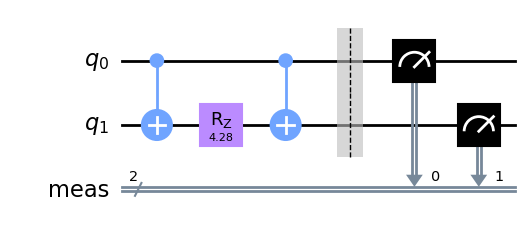

In [3]:
# Create a two-qubit qiskit circuit
theta = np.random.uniform(0, 4 * np.pi)
circuit1 = qiskit.QuantumCircuit(2)
circuit1.cx(0, 1)
circuit1.rz(theta, 1)
circuit1.cx(0, 1)
circuit1.measure_all()

# Draw circuit for visualization
circuit1.draw(output="mpl")

Using the same circuit from above as input, we will now compile it for QSCOUT and visualize the differences by drawing the compiled circuit. 

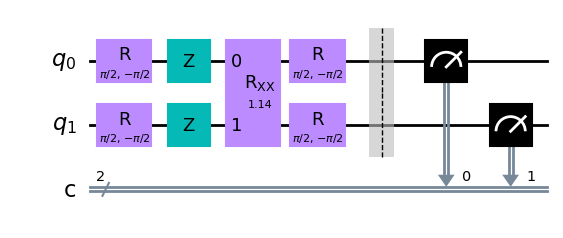

In [4]:
# Compile with qscout compile
compiler_output = provider.qscout_compile(circuit1)

# Call circuit from the compiler output to get the corresponding output circuit
output_circuit = compiler_output.circuit

# Visualize the compiled circuit
output_circuit.draw("mpl")

The resulting output is now a circuit compiled and optimized to QSCOUT's native operations. But there's more! With Superstaq's compilation, users can also get the corresponding Jaqal (see [Just another quantum assembly language](https://arxiv.org/abs/2008.08042)) program for their compiled circuit. The Jaqal program is a useful representation that highlights the sequence of pulse level single and two-qubit gates  that have to be executed on the trapped ions to realize the user's circuit. To view the jaqal program, users simply have to call `jaqal_program` on their `compiler_output`, and print to list it in a readable format. 

In [5]:
# Get jaqal program
print(compiler_output.jaqal_program)

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
MS allqubits[0] allqubits[1] 0 1.138001122955302
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
measure_all



Breaking down the printed Jaqal program, we see that we begin a 2-qubit quantum register with **allqubits[2]** in correspondance to our 2-qubit circuit. The **prepare_all** command prepares the state of all the qubits in the register in the $z$ basis as the standard. Next, the program describes the pulse-level gates to be used following the format outlined and described [here](https://www.sandia.gov/quantum/quantum-information-sciences/projects/qscout-jaqal/). For a quick reference, here is a brief description of the pulse-level gates and operations that are used in a Jaqal program: 

- **R** `<qubit> <axis-angle> <rotation-angle>` : Performs a counter-clockwise rotation around an axis in the equatorial plane of the Bloch sphere defined by `<axis-angle>` , measured counter-clockwise from the $x$ axis, by the angle defined by `<rotation-angle>`.
- **Rx** `<qubit> <rotation-angle>` : Performs a counter-clockwise rotation around the $x$ axis, by the angle defined by `<rotation angle>`.
- **Ry** `<qubit> <rotation-angle>` : Performs a counter-clockwise rotation around the $y$ axis, by the angle defined by `<rotation-angle>`.
- **Rz** `<qubit> <angle>` : Performs a counter-clockwise rotation around the $z$ axis, by the angle defined by `<rotation-angle>`.
- **Px** `<qubit>` : Performs a counter-clockwise rotation around the $x$ axis, by $\pi$. In other words, a Pauli $X$ gate.
- **Py** `<qubit>>` : Performs a counter-clockwise rotation around the $y$ axis, by $\pi$. In other words, Pauli $Y$ gate.
- **Pz** `<qubit>` : Performs a counter-clockwise rotation around the $z$ axis, by $\pi$. In other words, Pauli $Z$ gate.
- **Sx** `<qubit>` : Performs a counter-clockwise rotation around the $x$ axis, by $\pi/2$. This results in a $\sqrt{X}$ gate.
- **Sy** `<qubit>` : Performs a counter-clockwise rotation around the $y$ axis, by $\pi/2$. This results in a $\sqrt{Y}$ gate.
- **Sz** `<qubit>` : Performs a counter-clockwise rotation around the $z$ axis, by $\pi/2$. This results in a $\sqrt{Z}$ gate.
- **Sxd** `<qubit>` : Performs a clockwise rotation around the $x$ axis, by $\pi/2$. That is, a $\sqrt{X}^\dagger$ gate.
- **Syd** `<qubit>` : Performs a clockwise rotation around the $y$ axis, by $\pi/2$. That is, a $\sqrt{Y}^\dagger$ gate.
- **Szd** `<qubit>` : Performs a clockwise rotation around the $z$ axis, by $\pi/2$. That is, a $\sqrt{Z}^\dagger$ gate.
- **MS** `<qubit> <qubit> <axis-angle> <rotation-angle>` : This is the general two-qubit Mølmer–Sørensen gate used for entanglement. Supposing that $\theta$ and $\varphi$ represent the `<rotation-angle>` and `<axis-angle>` respectively, the general MS gate is given by, $$\exp\left(-i\left(\frac{\theta}{2}\right)(\cos \varphi X + \sin \varphi Y)^{\otimes 2}\right).$$
- **Sxx** `<qubit> <qubit>` : This is the XX version of two-qubit Mølmer–Sørensen gate, $$\exp \left(-i\left(\frac{\pi}{4}\right) X\otimes X\right).$$
- **measure_all** : Command to measure all qubits of the quantum register in the $z$ basis. 

The Jaqal program output is also very useful is showcasing when multiple gates are combined into a single gate block for execution -- or in the case of parallel gate blocks -- executed at the same time. These gate blocks are marked by the angle brakets like so,
<pre>
```
<
  // pulse-level gates
>
```
</pre>
providing the user more valuable context between the device execution and the original circuit representation. Further details on the verstaility of the Jaqal program can be found at this [reference](https://www.sandia.gov/quantum/quantum-information-sciences/projects/qscout-jaqal/).

## Multiple Circuits Compilation

All the functionalities we have seen so far can also be used on a multiple circuits input as well. To illustrate this, let us create a different, example two-qubit circuit (say, a Bell-state circuit):

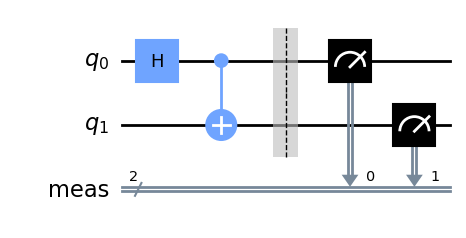

In [6]:
# Create second circuit
circuit2 = qiskit.QuantumCircuit(2)
circuit2.h(0)
circuit2.cx(0, 1)
circuit2.measure_all()

# Draw second circuit for visualization
circuit2.draw("mpl")

By passing multiple circuits as a list to the `qscout_compile` endpoint, we can compile all of them individually with a single call to `qscout_compile`. This will return all the corresponding compiled circuits and Jaqal programs back as a list, like so:  

In [7]:
# Create list of circuits
circuit_list = [circuit1, circuit2]

# Compile a list of circuits and their respective jaqal programs
compiler_output_list = provider.qscout_compile(circuit_list)
jaqal_output_list = compiler_output_list.jaqal_programs

Compiled circuit 1 

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
MS allqubits[0] allqubits[1] 0 1.138001122955302
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
measure_all



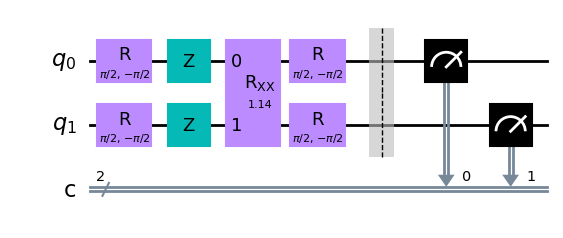

In [8]:
# To get the list of compiled output circuits from the compiler output list, call `circuits` instead of just `circuit` that is called for a single circuit input
output_circuits = compiler_output_list.circuits

# Visualize and get the jaqal program of the first compiled circuit
print("Compiled circuit 1 \n")
print(jaqal_output_list[0])
output_circuits[0].draw("mpl")

Compiled circuit 2 

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] 3.141592653589793 3.141592653589793
	R allqubits[1] 3.141592653589793 3.141592653589793
>
Sxx allqubits[0] allqubits[1]
<
	R allqubits[0] -1.5707963267948972 1.5707963267948966
	R allqubits[1] 0.0 1.570796326794898
>
Rz allqubits[0] -1.5707963267948966
measure_all



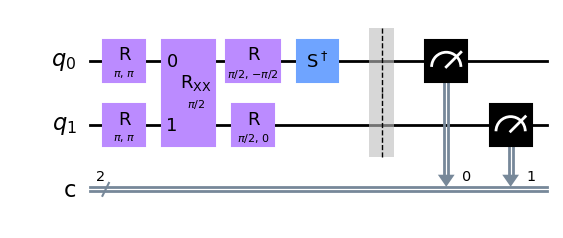

In [9]:
# Visualize and get the jaqal program of second compiled circuit
print("Compiled circuit 2 \n")
print(jaqal_output_list[1])
output_circuits[1].draw("mpl")

## Entangling Basis Compilation

When compiling to the QSCOUT gateset, we can also specify the type of entangling basis gate to utilize during the compilation -- either a $XX$ or $ZZ$. Let's consider the first circuit example for earlier but with a different, random $R_Z$ angle and single measurement:

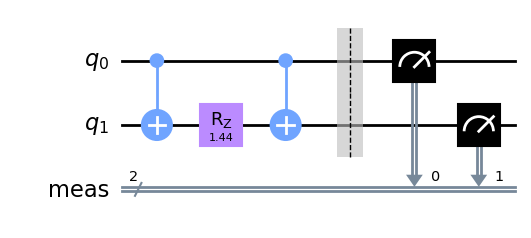

In [10]:
# Create circuit
theta = np.random.uniform(0, np.pi)
circuit = qiskit.QuantumCircuit(2)
circuit.cx(0, 1)
circuit.rz(theta, 1)
circuit.cx(0, 1)
circuit.measure_all()

# Visualize circuit
circuit.draw(output="mpl")

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
MS allqubits[0] allqubits[1] 0 1.442906408693394
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
measure_all



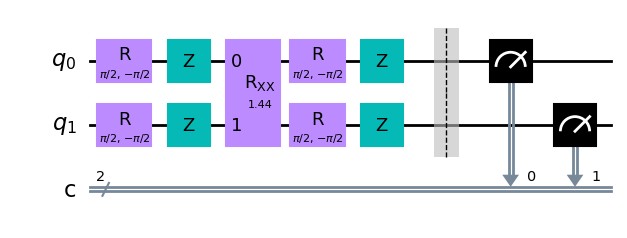

In [11]:
# Compile with XX entangling basis
compiler_output = provider.qscout_compile(circuit, base_entangling_gate="xx")

# Visualize and get jaqal program of the compiled circuit
print(compiler_output.jaqal_program)
compiler_output.circuit.draw(output="mpl")

As we can see above, we get the same compiled gate structure as before. This is because, by default, the $XX$ interaction is used, and we observe that it uses the $R_{XX}$ gate as the base entangling gate in the compiled circuit. Similarly, let's take a look at the compiled circuit if we now specify the compiler to use the $ZZ$ interaction instead:

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
ZZ allqubits[0] allqubits[1] 1.442906408693394
measure_all



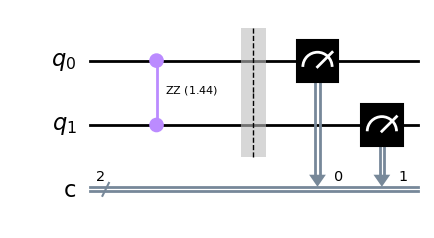

In [12]:
# Compile with zz entangling basis
compiler_output = provider.qscout_compile(circuit, base_entangling_gate="zz")

# Get jaqal program and draw circuit
print(compiler_output.jaqal_program)
compiler_output.circuit.draw(output="mpl")

Looking at the compiled circuit above, we can see that by specifying the $ZZ$ entangling basis, we use $R_{ZZ}$ gate as the base entangling gate and the remaining single-qubit gates are compiled and optimized accordingly. 

## Swap Mirroring

In addition to specifying the type of base entangling gate to use for the compilation and optimization, we can also specify whether to use mirror swapping to help reduce the two-qubit gate overhead of the circuit. By default, it is not enabled; but we will see the differences in circuit compilation by compiling to a random quantum volume model circuit. You can learn more about quantum volume and randomized circuits [here](https://arxiv.org/abs/1811.12926).

### Create random Quantum Volume (QV) circuit

In [13]:
# Generate a random QV circuit
circ = qiskit.circuit.library.QuantumVolume(num_qubits=2, depth=4, seed=123)
circ.measure_all()

### Compile without swap mirroring

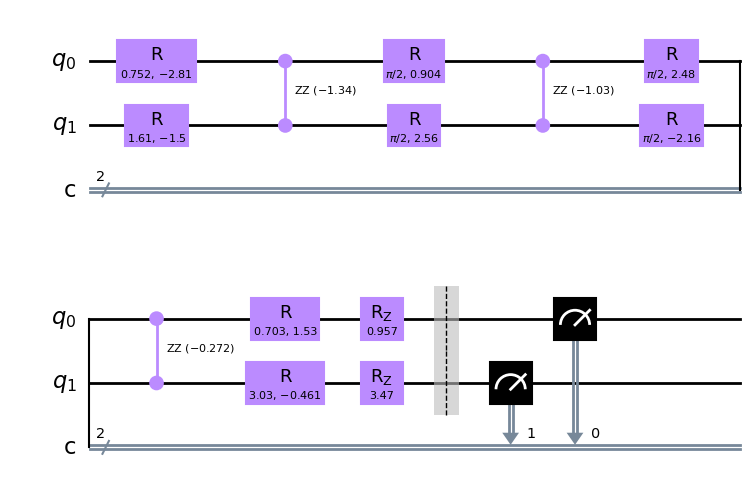

In [14]:
# Compile with no swap mirroring
output_nsm = provider.qscout_compile(circ, mirror_swaps=False, base_entangling_gate="zz")

# Visualize the circuit
circ_nsm = output_nsm.circuit
circ_nsm.draw("mpl", fold=10)

### Compile with swap mirroring

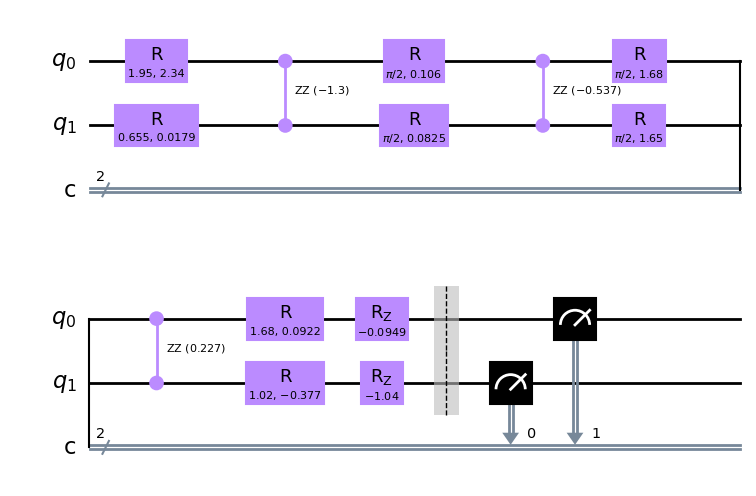

In [15]:
# Compile with swap mirroring
output_wsm = provider.qscout_compile(circ, mirror_swaps=True, base_entangling_gate="zz")

# Visualize the circuit
circ_wsm = output_wsm.circuit
circ_wsm.draw("mpl", fold=10)

With the use of swap mirroring, we note that the classical bits associated with each measurement have now been swapped in the compiled circuit. This is also displayed with the measurement indices in the above compiled circuit compared to the previous compiled circuit that does not have swap mirroring enabled.

### Return final logical to physical qubit mapping

In [16]:
# Return final qubit map for non swap-mirrored circuit
map_nsm = output_nsm.final_logical_to_physical
print("Non swap-mirrored mapping:", map_nsm)

# Return final qubit map for swap-mirrored circuit
map_wsm = output_wsm.final_logical_to_physical
print("Swap-mirrored mapping:", map_wsm)

Non swap-mirrored mapping: {0: 0, 1: 1}
Swap-mirrored mapping: {0: 1, 1: 0}


## Using Superstaq Simulator

Lastly, we will go over how to submit a circuit to a backend and simulate it. This feature is available to free trial users, and can be done by passing the `"dry-run"` method parameter when calling `run()` to instruct Superstaq to simulate the circuit. 

In [17]:
# Example Bell state circuit
qc = qiskit.QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure(0, 0)
qc.measure(1, 1)

# Get qscout backend from provider
backend = provider.get_backend("sandia_qscout_qpu")

job = backend.run(
    qc, shots=100, method="dry-run"
)  # specify "dry-run" as the method to run Superstaq simulation

# Get the counts from the measurement
print(job.result().get_counts())

{'00': 47, '11': 53}
